# US-Congress Members Trading Analysis
By Liam Kane, Panagiotis Patsias, Liam Tessendorf, and Maximilian von Willich

## Prelims

In [32]:
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from node2vec import Node2Vec
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

np.random.seed(42)
random.seed(42)

## Graph ML

For the Graph ML section, we had to create new networks that were divided yearly. Each graph's nodes corresponded to individual Congress members, while edges were created if two members traded the same stock within a 7-day window. The data used in this section was taken from [this](https://github.com/adrianmross/congress_trades_dashboard/tree/main) GitHub repo 

### Data preprocessing

In [33]:
df = pd.read_csv("../data/external/congress_trading_data_adrianmross.csv")
df["transaction_date"] = pd.to_datetime(df["transaction_date"])
df["type"] = df["type"].replace({"sale_partial": "sale", "sale_full": "sale"})

It is interesting to see how many trades happened in each year. We can see that the number of trades has been increasing over the years, reaching a peak in 2020. This is likely due to the Coronavirus pandemic, which caused a lot of uncertainty in the stock market.

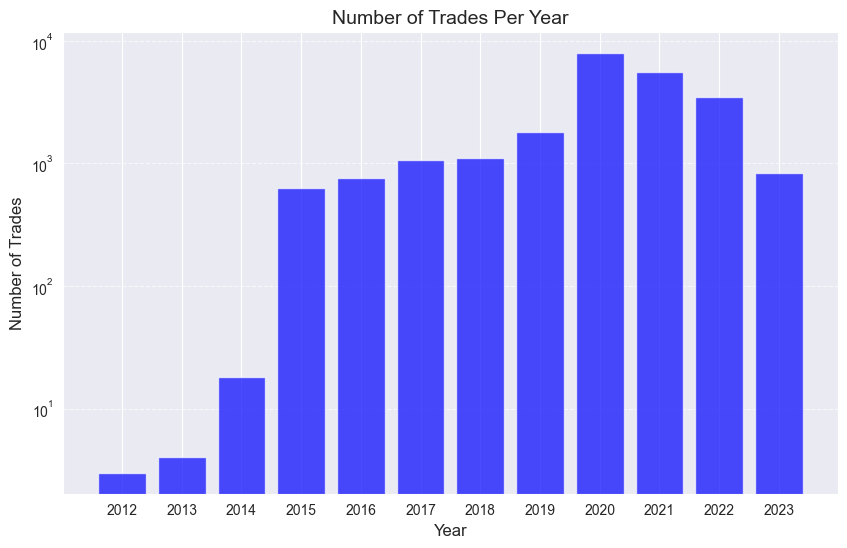

In [34]:
trade_amounts = {}
for year in range(df["transaction_date"].min().year, df["transaction_date"].max().year + 1):
    yearly_trades = df[df["transaction_date"].dt.year == year]
    trade_amounts[year] = len(yearly_trades)

plt.figure(figsize=(10, 6))
plt.bar(list(trade_amounts.keys()), list(trade_amounts.values()), color="blue", alpha=0.7)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Trades", fontsize=12)
plt.title("Number of Trades Per Year", fontsize=14)
plt.xticks(list(trade_amounts.keys()), fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.yscale("log")

### Graph creation

In [35]:
def create_graph(df: pd.DataFrame) -> nx.Graph:
    G = nx.Graph()

    party_colors = {"Democrat": "blue", "Republican": "red"}
    party_map = {row["name"]: row["party"] for _, row in df.iterrows()}

    for rep in df["name"].unique():
        G.add_node(
            rep, color=party_colors.get(party_map[rep], "gray")
        )  # Default to gray if party unknown

    for ticker in df["ticker"].unique():
        ticker_trades = df[df["ticker"] == ticker]

        for i in range(len(ticker_trades)):
            for j in range(i + 1, len(ticker_trades)):
                rep1 = ticker_trades.iloc[i]["name"]
                rep2 = ticker_trades.iloc[j]["name"]
                date1 = ticker_trades.iloc[i]["transaction_date"]
                date2 = ticker_trades.iloc[j]["transaction_date"]
                trans_type1 = ticker_trades.iloc[i]["type"]
                trans_type2 = ticker_trades.iloc[j]["type"]

                if rep1 != rep2 and abs((date1 - date2).days) <= 7 and trans_type1 == trans_type2:
                    G.add_edge(rep1, rep2, stock=ticker)

    return G

In [36]:
dfs_by_year = {year: group for year, group in df.groupby(df["transaction_date"].dt.year)}
graphs_by_year = {year: create_graph(df_year) for year, df_year in dfs_by_year.items()}

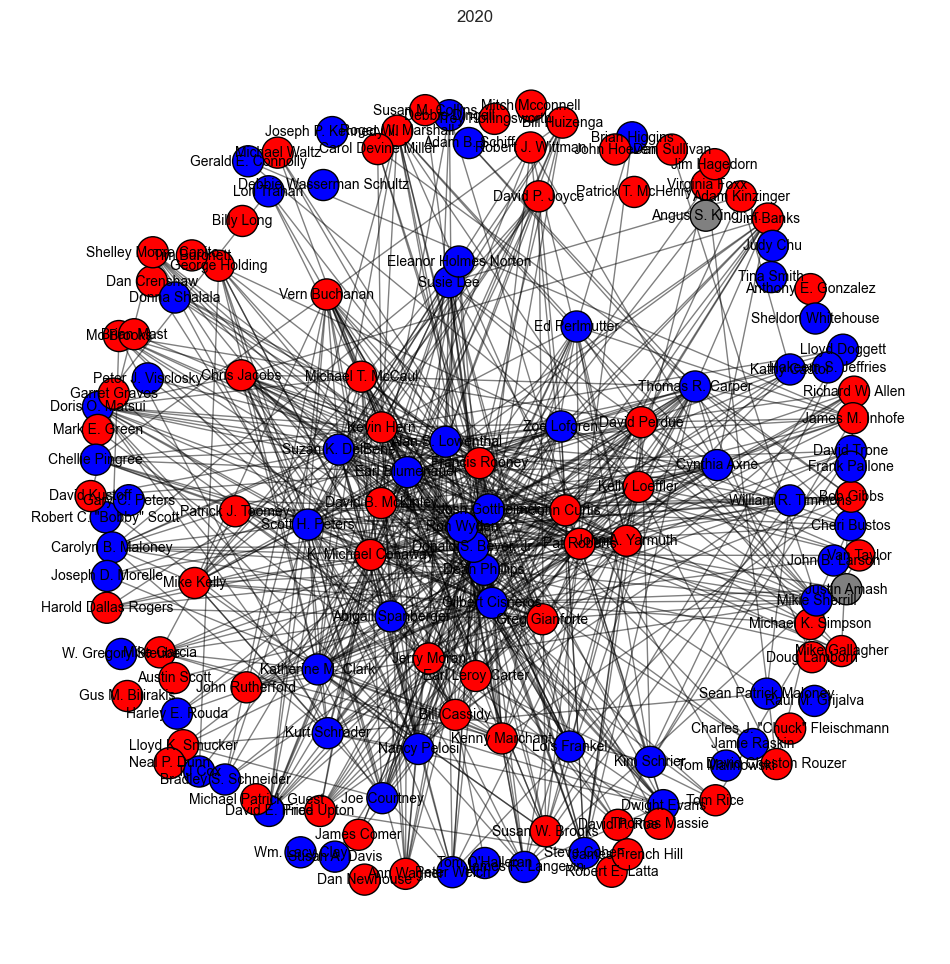

In [37]:
def plot_graph(G, year):
    plt.figure(figsize=(12, 12))

    pos = nx.spring_layout(G, seed=42, k=1.5)

    node_colors = [data["color"] for _, data in G.nodes(data=True)]

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors, edgecolors="black")
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    plt.title(year)
    plt.axis("off")
    plt.show()


plot_graph(graphs_by_year[2020], "2020")

In above plot, one can see the plot of the network of Congress members who traded the same stock within a 7-day window in 2020. The nodes are colored according to the party of the Congress member, with blue representing Democrats, red representing Republicans, and gray representing unknown parties.

### Embeddings using Node2Vec

In [38]:
def create_embeddings(graph):
    node2vec = Node2Vec(graph, dimensions=16, walk_length=15, num_walks=100, workers=1, seed=1)
    model = node2vec.fit(window=10, min_count=1)

    embeddings = pd.DataFrame(
        [model.wv.get_vector(str(node)) for node in graph.nodes()], index=graph.nodes
    )
    embeddings.index.name = "name"
    embeddings.reset_index(inplace=True)
    return embeddings


embeddings_by_year = {year: create_embeddings(graph) for year, graph in graphs_by_year.items()}

Generating walks (CPU: 1): 100%|██████████| 100/100 [00:00<00:00, 929.34it/s]


### Calculating Returns of individual Congress Members

We calculated yearly trading returns for each Congress member and normalized these returns based on their tenure in Congress and by using the S&P500 as a baseline. This normalization ensured fair comparisons across members with varying lengths of service. Ultimately, these normalized returns served as the target variable for our predictive analysis.

In [39]:
df_returns = pd.read_csv("../data/external/congress_returns_adrianmross.csv")
df_returns["date"] = pd.to_datetime(df_returns["date"])
df_returns = df_returns[df_returns["date"].dt.year > 2016]

df_sp500 = pd.read_csv("../data/external/s&p500_returns_adrianmross.csv")
df_sp500["date"] = pd.to_datetime(df_sp500["date"])

In [40]:
member_active_periods = (
    df_returns.groupby("name")
    .agg(start_date=("date", "min"), end_date=("date", "max"))
    .reset_index()
)


def calculate_yearly_returns(returns_df):
    returns_df["year"] = returns_df["date"].dt.year

    yearly_metrics = returns_df.groupby(["name", "year"]).agg({"return": ["mean", "std", "sum"]})
    yearly_metrics.columns = ["avg_return", "return_volatility", "cumulative_return"]
    yearly_metrics.reset_index(inplace=True)

    return yearly_metrics


historical_returns = calculate_yearly_returns(df_returns)
historical_returns = pd.merge(historical_returns, member_active_periods, on="name", how="left")

In [41]:
def calculate_sp500_cumulative_return(start_date, end_date):
    mask = (df_sp500["date"] >= start_date) & (df_sp500["date"] <= end_date)
    sp500_period = df_sp500.loc[mask]
    cumulative_return = sp500_period["daily_return"].sum()
    return cumulative_return

In [42]:
historical_returns["sp500_cumulative_return"] = historical_returns.apply(
    lambda row: calculate_sp500_cumulative_return(
        max(row["start_date"], pd.Timestamp(f"{row['year']}-01-01")),
        min(row["end_date"], pd.Timestamp(f"{row['year']}-12-31")),
    ),
    axis=1,
)
historical_returns["normalized_return"] = (
    historical_returns["cumulative_return"] - historical_returns["sp500_cumulative_return"]
)

historical_returns_by_year = {year: df for year, df in historical_returns.groupby("year")}

In [43]:
common_years = set(embeddings_by_year.keys()) & set(historical_returns_by_year.keys())
features_by_year = {
    year: pd.merge(
        embeddings_by_year[year], historical_returns_by_year[year], on="name", how="inner"
    )
    for year in common_years
}

In [44]:
all_features = pd.concat(
    features_by_year.values(), keys=features_by_year.keys(), names=["year", "index"]
)

all_features.reset_index(level=1, drop=True, inplace=True)
df_features = all_features

We now have all the features we need to start testing some ML algorithms. But first, to reduce the complexity of this task, we define a threshold in order to change this task into a classification problem.

In [45]:
def calc_threshold(df):
    returns = df["normalized_return"].to_list()
    median_return = np.median(returns)
    std_return = np.std(returns)
    threshold = median_return + (std_return * 0.2)
    return threshold


threshold = calc_threshold(df_features)

In [46]:
df_features["category"] = df_features["normalized_return"].apply(
    lambda x: 1 if x > threshold else 0
)
print(
    len(df_features[df_features["category"] == 1]), len(df_features[df_features["category"] == 0])
)

125 305


We define the dummy variable 1 as anomalous returns, and the dummy variable 0 as normal returns.

Now we can also do a train test split. We split the data into a training set that contains all the data up to 2022 and a test set that contains all the data from 2023 onwards.

In [47]:
df_train = df_features[df_features["year"] < 2023]
df_test = df_features[df_features["year"] >= 2023]

In [48]:
X_train = df_train.drop(
    [
        "name",
        "avg_return",
        "return_volatility",
        "cumulative_return",
        "start_date",
        "end_date",
        "sp500_cumulative_return",
        "normalized_return",
        "category",
        "year",
    ],
    axis=1,
)
y_train = df_train["category"]

X_test = df_test.drop(
    [
        "name",
        "avg_return",
        "return_volatility",
        "cumulative_return",
        "start_date",
        "end_date",
        "sp500_cumulative_return",
        "normalized_return",
        "category",
        "year",
    ],
    axis=1,
)
y_test = df_test["category"]

## Training some models

We tried three different models: Random Forest, Logistic Regression, and XGBoost. We used the same features for all models and compared their performance. Since XGBoost performed the best, we show it here. For the others, please see `notebooks/3.01-lte-graph-ml-2.ipynb`.

### XGBoost

Accuracy: 0.6949152542372882

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.86      0.80        42
           1       0.45      0.29      0.36        17

    accuracy                           0.69        59
   macro avg       0.60      0.58      0.58        59
weighted avg       0.66      0.69      0.67        59



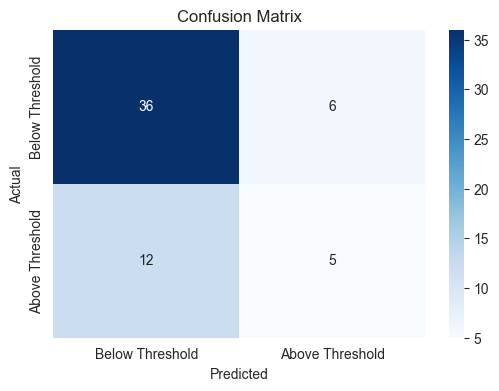

In [49]:
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0])
    / len(y_train[y_train == 1]),  # Class weight adjustment
    random_state=42,
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Below Threshold", "Above Threshold"],
    yticklabels=["Below Threshold", "Above Threshold"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()